

## Convolutional Neural Networks

---

In this notebook, we train a CNN on augmented images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database

In [19]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### 2. Visualize the First 24 Training Images

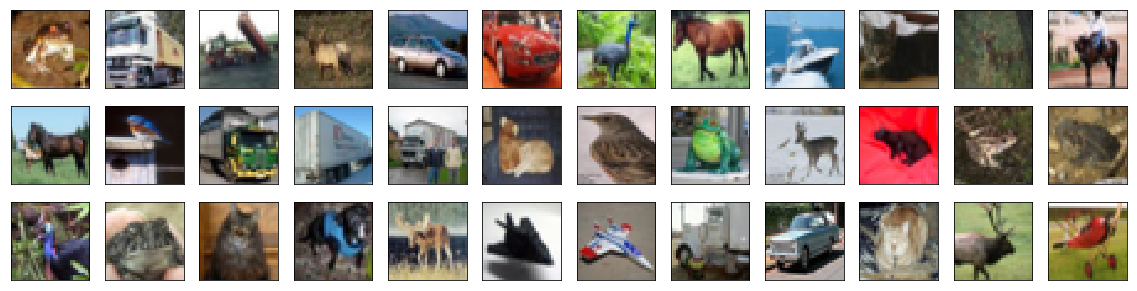

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [21]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [22]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Create and Configure Augmented Image Generator

In [23]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

### 6. Visualize Original and Augmented Images

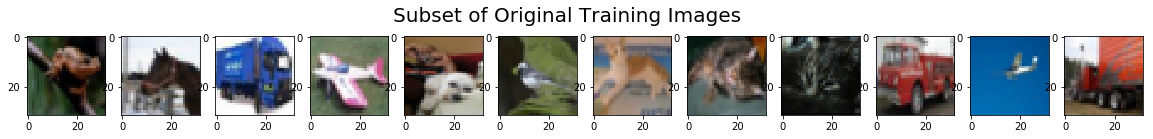

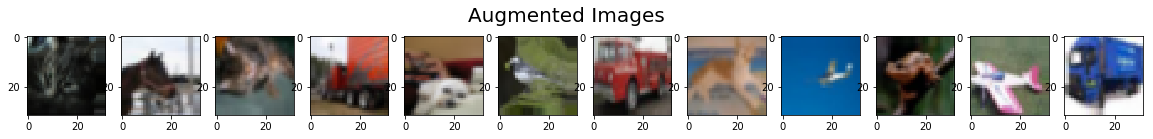

In [24]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 64)          0         
__________

### 8. Compile the Model 

In [26]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 9. Train the Model 

In [27]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/100
 - 46s - loss: 1.6575 - acc: 0.3972 - val_loss: 1.3684 - val_acc: 0.5014

Epoch 00001: val_loss improved from inf to 1.36837, saving model to aug_model.weights.best.hdf5
Epoch 2/100
 - 50s - loss: 1.3956 - acc: 0.4974 - val_loss: 1.2576 - val_acc: 0.5434

Epoch 00002: val_loss improved from 1.36837 to 1.25762, saving model to aug_model.weights.best.hdf5
Epoch 3/100
 - 50s - loss: 1.2838 - acc: 0.5430 - val_loss: 1.1833 - val_acc: 0.5862

Epoch 00003: val_loss improved from 1.25762 to 1.18327, saving model to aug_model.weights.best.hdf5
Epoch 4/100
 - 47s - loss: 1.2199 - acc: 0.5689 - val_loss: 1.1302 - val_acc: 0.6068

Epoch 00004: val_loss improved from 1.18327 to 1.13018, saving model to aug_model.weights.best.hdf5
Epoch 5/100
 - 45s - loss: 1.1844 - acc: 0.5838 - val_loss: 1.0820 - val_acc: 0.6248

Epoch 00005: val_loss improved from 1.13018 to 1.08199, saving model to aug_model.weights.best.hdf5
Epoch 6/100
 - 44s - loss: 1.1692 - acc: 0.5903 - val_loss: 1.0778 - val_a

 - 48s - loss: 1.7518 - acc: 0.3899 - val_loss: 1.5253 - val_acc: 0.4612

Epoch 00058: val_loss did not improve from 1.03681
Epoch 59/100
 - 46s - loss: 1.7434 - acc: 0.3931 - val_loss: 1.5074 - val_acc: 0.4642

Epoch 00059: val_loss did not improve from 1.03681
Epoch 60/100
 - 49s - loss: 1.7457 - acc: 0.3914 - val_loss: 1.5934 - val_acc: 0.4508

Epoch 00060: val_loss did not improve from 1.03681
Epoch 61/100
 - 48s - loss: 1.7516 - acc: 0.3928 - val_loss: 1.5089 - val_acc: 0.4612

Epoch 00061: val_loss did not improve from 1.03681
Epoch 62/100
 - 46s - loss: 1.7618 - acc: 0.3844 - val_loss: 1.7281 - val_acc: 0.3902

Epoch 00062: val_loss did not improve from 1.03681
Epoch 63/100
 - 46s - loss: 1.7767 - acc: 0.3821 - val_loss: 1.6067 - val_acc: 0.4350

Epoch 00063: val_loss did not improve from 1.03681
Epoch 64/100
 - 46s - loss: 1.7849 - acc: 0.3775 - val_loss: 1.5498 - val_acc: 0.4576

Epoch 00064: val_loss did not improve from 1.03681
Epoch 65/100
 - 46s - loss: 1.8010 - acc: 0.373

### 10. Load the Model with the Best Validation Accuracy

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

In [11]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.6825
